# Validation/Verification & Performance comparison for LOGIC gates with multiple hidden layers and multiple neurons

For Google Colab or Kaggle install crysx_nn

In [ ]:
! pip install --upgrade https://github.com/manassharma07/crysx_nn/tarball/main

## Import stuff

In [1]:
import numpy as np
print('numpy',np.__version__)

import matplotlib.pyplot as plt


# Import loss functions
from crysx_nn.loss import MSE_loss, MSE_loss_grad
from crysx_nn.loss import BCE_loss, BCE_loss_grad
# Import activation functions
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import ReLU, ReLU_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import Tanh_offset, Tanh_offset
# Import neural network functions
from crysx_nn.network import back_propagation, back_propagation_fast
from crysx_nn.network import nn_optimize, nn_optimize_fast
from crysx_nn.network import forward_feed
from crysx_nn.network import visualize


from tqdm.notebook import tqdm


# import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
print('tf',tf.__version__)

import torch, torchvision
print('torch',torch.__version__)
rng = np.random.default_rng()
import time
from timeit import default_timer as timer

numpy 1.19.2


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\crysx_nn\network.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


tf 2.2.3
torch 1.10.1


## Ensure that evertyhing is only using CPU

In [2]:
torch.cuda.is_available()

False

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
print(tf.test.is_built_with_cuda())

True


## Check if NumPy is linked with MKL or not

In [6]:
np.show_config()

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/crysx_nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = [

## Start with the common stuff

In [7]:
nInputs = 2 # No. of features
nOutputs = 1
neurons_per_layer = [10,1] # Hidden layers and output layer
activation_func_names = ['Sigmoid','Sigmoid']
nLayers = len(neurons_per_layer)
eeta = 0.5
nEpochs=10**4
batchSize = 4

#### Activation function dictionary for all the frameworks

In [8]:


act_func_dict_PyTorch = {'Sigmoid':torch.nn.Sigmoid(),'ReLU':torch.nn.ReLU(),'ELU':torch.nn.ELU(), 'Hardshrink' : torch.nn.Hardshrink(),'Hardsigmoid':torch.nn.Hardsigmoid(),\
                 'Hardtanh':torch.nn.Hardtanh(),'Hardswish':torch.nn.Hardswish(),'LeakyReLU':torch.nn.LeakyReLU(),'LogSigmoid':torch.nn.LogSigmoid(),\
                 'Tanh':torch.nn.Tanh(),'Softmax':torch.nn.Softmax(dim=1),'Softmin':torch.nn.Softmin(dim=1),'LogSoftmax':torch.nn.LogSoftmax()}
act_func_dict_tensorflow = {'Sigmoid':'sigmoid','Softmax':'softmax','ReLU':'relu','LeakyReLU':'leakyrelu'}



## Visualize 

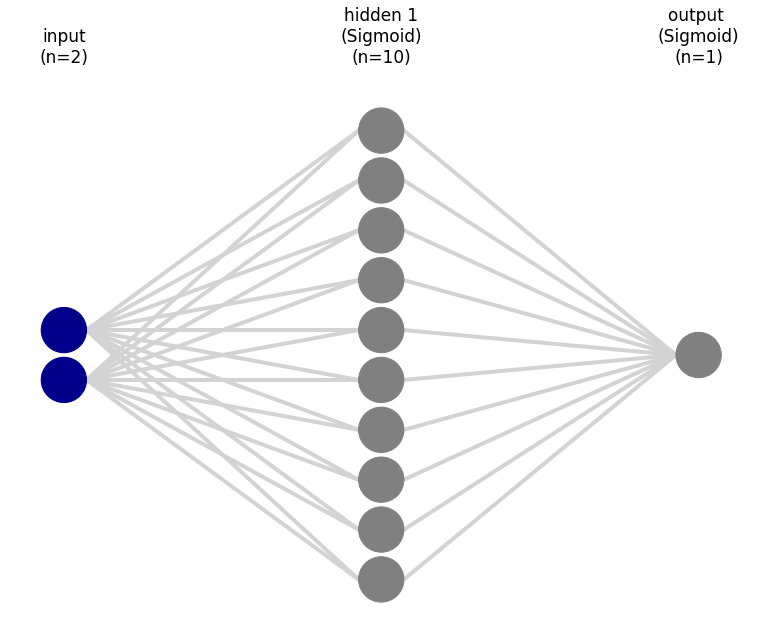

In [9]:
visualize(nInputs, neurons_per_layer, activation_func_names)

## Set inputs

In [10]:
inputs = np.array([[0.,0.,1.,1.],[0.,1.,0.,1.]]).T.astype('float32')
print(inputs)
print(inputs.dtype)


[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
float32


In [11]:
# AND function
outputAND = np.array([0.,0.,0.,1.])
outputAND = np.asarray([outputAND]).T
# OR function
outputOR = np.array([0.,1.,1.,1.])
outputOR = np.asarray([outputOR]).T
# NAND function
outputNAND = np.array([1.,1.,1.,0.])
outputNAND = np.asarray([outputNAND]).T
# XOR function
outputXOR = np.array([0.,1.,1.,0.])
outputXOR = np.asarray([outputXOR]).T

## Set outputs

In [12]:
# outputs = outputAND
# outputs = outputOR
# outputs = outputNAND
outputs = outputXOR
outputs = outputs.astype('float32')
print(outputs)
print(outputs.dtype)

[[0.]
 [1.]
 [1.]
 [0.]]
float32


# Keras implementation

In the following we have to be careful and change the network nodes, and layers manually. 

TODO: Make the neural network be generated in a loop automatically using the parameters already defined.

In [13]:
# # define the keras model
# model = Sequential()
# model.add(Dense(100, input_dim=2, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(100, activation='sigmoid', use_bias=True))
# model.add(Dense(1, activation='sigmoid', use_bias=True))

# model.summary()

## Make the neural network programatically

In [14]:
# define the keras model
model = Sequential()
# First Hidden layer
model.add(Dense(neurons_per_layer[0], input_dim=nInputs, activation=act_func_dict_tensorflow[activation_func_names[0]], use_bias=True))

if nLayers>1:
    # Hidden layers
    for i in range(nLayers-2):
        model.add(Dense(neurons_per_layer[i], activation=act_func_dict_tensorflow[activation_func_names[i]], use_bias=True))
    # Output layer
    model.add(Dense(neurons_per_layer[nLayers-1], activation=act_func_dict_tensorflow[activation_func_names[nLayers-1]], use_bias=True))
    
model.summary()
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                30        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


## Check the initial weights and biases for each layer

Note how the weights matrix is not 4x2 but rather 2x4

In [15]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.70278734 -0.25730163  0.07464916 -0.6665568  -0.0525406   0.6774263
   0.18401009  0.4483356  -0.00240862 -0.11098409]
 [-0.5718324  -0.46625894  0.32818955 -0.1339764  -0.09532726  0.22892398
  -0.31128818 -0.33961475  0.06313229 -0.5713612 ]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Weights for layer  2
[[-0.3633899 ]
 [ 0.0976041 ]
 [-0.07739747]
 [-0.5338105 ]
 [ 0.44176143]
 [-0.309375  ]
 [ 0.55701166]
 [ 0.04354465]
 [-0.5438871 ]
 [ 0.37413698]]

 Biases for layer  2
[0.]


## Save the weights generated by tf.keras and use them for our implementation as well

In [16]:
weightsOriginal = []
biasesOriginal = []


for i in range(nLayers):
    weightsOriginal.append(model.layers[i].get_weights()[0].T)
    biasesOriginal.append(model.layers[i].get_weights()[1].T)

print('Weights matrices: ',weightsOriginal)
print('Biases: ',biasesOriginal)

Weights matrices:  [array([[ 0.70278734, -0.5718324 ],
       [-0.25730163, -0.46625894],
       [ 0.07464916,  0.32818955],
       [-0.6665568 , -0.1339764 ],
       [-0.0525406 , -0.09532726],
       [ 0.6774263 ,  0.22892398],
       [ 0.18401009, -0.31128818],
       [ 0.4483356 , -0.33961475],
       [-0.00240862,  0.06313229],
       [-0.11098409, -0.5713612 ]], dtype=float32), array([[-0.3633899 ,  0.0976041 , -0.07739747, -0.5338105 ,  0.44176143,
        -0.309375  ,  0.55701166,  0.04354465, -0.5438871 ,  0.37413698]],
      dtype=float32)]
Biases:  [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), array([0.], dtype=float32)]


## Compile model

In [17]:
# compile the keras model

# In the following manner we can't set the learning rate of the optimizer
# model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

# So use the following instead
model.compile(loss='mse', optimizer=optimizers.SGD(learning_rate=eeta), metrics=['mse'])



## Forward feed

Note: Batch size=4 indicates that we are using all the training data(examples) and therefore this is the equivalent of my own implementation as I don't have stochastic/minibatch gradient descent implementation yet.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [18]:
model.evaluate(inputs, outputs, batch_size=batchSize)

1/1 [==============================] - 0s 1ms/step - loss: 0.2528 - mse: 0.2528


[0.25284990668296814, 0.25284990668296814]

## Does tf.model.evaluate change the weights and biases?

In [19]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.70278734 -0.25730163  0.07464916 -0.6665568  -0.0525406   0.6774263
   0.18401009  0.4483356  -0.00240862 -0.11098409]
 [-0.5718324  -0.46625894  0.32818955 -0.1339764  -0.09532726  0.22892398
  -0.31128818 -0.33961475  0.06313229 -0.5713612 ]]

 Biases for layer  1
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

 Weights for layer  2
[[-0.3633899 ]
 [ 0.0976041 ]
 [-0.07739747]
 [-0.5338105 ]
 [ 0.44176143]
 [-0.309375  ]
 [ 0.55701166]
 [ 0.04354465]
 [-0.5438871 ]
 [ 0.37413698]]

 Biases for layer  2
[0.]


From the above, we can be sure that it does not change the weights and biases

## Fit 1 epoch  (forward feed, backpropagation, updating the weights, biases)

Let us just try to see and compare the error after just 1 epoch. 

We should expect the model to perform forward feed, calculate loss/error,
perform backpropagation,
and adjust the weights and biases based on the learning rate.

Note: Batch size=32 indicates that we are using all the training data(examples) in batches.

References: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

In [20]:
# fit the keras model on the dataset
model.fit(inputs, outputs, epochs=1, batch_size=batchSize)

1/1 [==============================] - 0s 0s/step - loss: 0.2528 - mse: 0.2528


## Now the weights and biases must have been updated

In [21]:
for i in range(nLayers):
    print('\n Weights for layer ',i+1)
    print(model.layers[i].get_weights()[0])
    print('\n Biases for layer ',i+1)
    print(model.layers[i].get_weights()[1])
# model.layers[0].get_biases()


 Weights for layer  1
[[ 0.70249224 -0.2570663   0.07449458 -0.667539   -0.05175632  0.6767914
   0.18495744  0.44839457 -0.00336091 -0.11007094]
 [-0.57230353 -0.4660356   0.3280369  -0.13550541 -0.09446446  0.22798672
  -0.31030914 -0.3395402   0.06208051 -0.57061636]]

 Biases for layer  1
[-0.00058565  0.00033445 -0.00025053 -0.00174515  0.00142407 -0.00105429
  0.00165043  0.00011227 -0.00174595  0.00121267]

 Weights for layer  2
[[-0.35694686]
 [ 0.1025601 ]
 [-0.07019618]
 [-0.52887547]
 [ 0.44790927]
 [-0.3011586 ]
 [ 0.5631711 ]
 [ 0.05006093]
 [-0.5373439 ]
 [ 0.3792238 ]]

 Biases for layer  2
[0.01285032]


## Now let us do a forward feed again and calculate the loss/error

In [22]:
out = model.evaluate(inputs, outputs, batch_size=batchSize)
print(out)

1/1 [==============================] - 0s 0s/step - loss: 0.2518 - mse: 0.2518
[0.2518008053302765, 0.2518008053302765]


### The above result, compares well with the result from my own implementation (when biases are updated independently)

## Now let us let the model train for 10^4 epochs



In [23]:
%%time
# fit the keras model on the dataset
# history = model.fit(tf.convert_to_tensor(inputs, dtype=tf.float32), tf.convert_to_tensor(outputs, dtype=tf.float32), epochs=nEpochs, batch_size=nSamples, verbose=0)
history = model.fit(inputs, outputs, epochs=nEpochs, batch_size=batchSize, verbose=0)

Wall time: 6.78 s


Turns out that this was quite slow. At first, I thought that the problem was that it was printing at each epoch. So I set the verbose=0 (silent). But still, it was incredibly slow compared to my implementation as well as PyTorch, even though we used own for loop in both the cases.

In [24]:
history.history

{'loss': [0.2518008351325989,
  0.25115469098091125,
  0.2507587969303131,
  0.25051674246788025,
  0.2503684163093567,
  0.25027719140052795,
  0.25022053718566895,
  0.2501848340034485,
  0.2501617968082428,
  0.25014641880989075,
  0.250135600566864,
  0.2501276731491089,
  0.2501213550567627,
  0.25011610984802246,
  0.25011149048805237,
  0.2501072287559509,
  0.2501031756401062,
  0.2500993013381958,
  0.2500954568386078,
  0.25009170174598694,
  0.2500879764556885,
  0.2500842809677124,
  0.25008058547973633,
  0.25007691979408264,
  0.25007322430610657,
  0.25006958842277527,
  0.2500659227371216,
  0.2500622868537903,
  0.2500585913658142,
  0.2500549554824829,
  0.2500512897968292,
  0.2500476539134979,
  0.25004398822784424,
  0.25004032254219055,
  0.25003671646118164,
  0.25003308057785034,
  0.25002944469451904,
  0.25002577900886536,
  0.25002214312553406,
  0.25001850724220276,
  0.25001487135887146,
  0.2500112056732178,
  0.25000759959220886,
  0.2500039339065552,
  0

## Now also let us have a look at the predictions for the sake of the tutorial

In [25]:
# make probability predictions with the model
predictions = model.predict(inputs)
print(predictions)

[[0.01943889]
 [0.9763046 ]
 [0.9762324 ]
 [0.02642027]]


## We have seen how to initialize custom weights/biases, perform forward feed, train/optimize the model, and finally how to check the updated parameters.


## Let us now see how we can see the input/output at each layer for debugging purposes.

In [26]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 1), dtype=float32)


In [27]:

for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    print(model.layers[i].input)
    print('\n Outputs for layer ',i+1)
    print(model.layers[i].output)


 Inputs for layer  1
Tensor("dense_input:0", shape=(None, 2), dtype=float32)

 Outputs for layer  1
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Inputs for layer  2
Tensor("dense/Identity:0", shape=(None, 10), dtype=float32)

 Outputs for layer  2
Tensor("dense_1/Identity:0", shape=(None, 1), dtype=float32)


## We can't really see any numbers in the above output
## So we need to do something more

In [28]:
for i in range(nLayers):
    print('\n Inputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).input)
    layerInput = func([inputs])  # input_data is a numpy array
    print(layerInput)
    print('\n Outputs for layer ',i+1)
    func = K.function([model.get_layer(index=0).input], model.get_layer(index=i).output)
    layerOutput = func([inputs])  # input_data is a numpy array
    print(layerOutput)





 Inputs for layer  1
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]

 Outputs for layer  1
[[8.9731216e-01 8.0938011e-01 4.9281690e-01 8.9757013e-01 8.7108290e-01
  4.0012529e-01 4.1224352e-01 5.3629172e-01 3.8813007e-01 6.5240777e-01]
 [8.5827321e-02 5.0524986e-01 5.9328848e-01 2.5510073e-02 5.8874732e-01
  4.8483393e-01 1.9809425e-02 1.8061799e-01 5.8529204e-01 9.6393645e-02]
 [9.9965382e-01 6.7632127e-01 5.2314788e-01 2.3905367e-02 7.0634389e-01
  6.1389863e-01 7.6201230e-01 6.0291743e-01 4.8134053e-01 7.4388272e-01]
 [9.6876746e-01 3.3446249e-01 6.2221694e-01 7.3163719e-05 3.3758271e-01
  6.9168103e-01 8.4466904e-02 2.2444421e-01 6.7371660e-01 1.4168736e-01]]

 Inputs for layer  2
[[8.9731216e-01 8.0938011e-01 4.9281690e-01 8.9757013e-01 8.7108290e-01
  4.0012529e-01 4.1224352e-01 5.3629172e-01 3.8813007e-01 6.5240777e-01]
 [8.5827321e-02 5.0524986e-01 5.9328848e-01 2.5510073e-02 5.8874732e-01
  4.8483393e-01 1.9809425e-02 1.8061799e-01 5.8529204e-01 9.6393645e-02]
 [9.9965382e-01 6.7632127

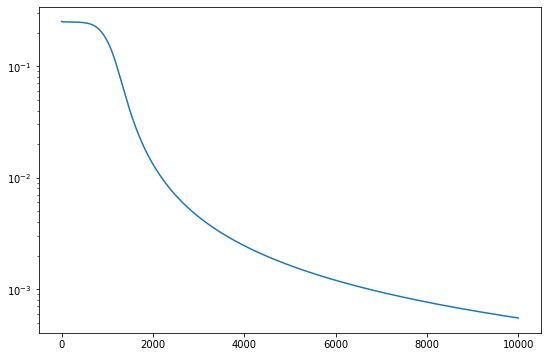

In [29]:
# Plot the error vs epochs
plt.plot(history.history['loss'])
plt.yscale('log')
plt.show()

# My implementation

## Forwad feed once

In [30]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# Error
print('Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.36081412, 0.38550207, 0.5813188 , 0.46655592, 0.47618622,
        0.55698234, 0.4228003 , 0.4159031 , 0.5157778 , 0.36092278],
       [0.6688055 , 0.4360271 , 0.51865363, 0.33926827, 0.48686787,
        0.663164  , 0.54587317, 0.61024344, 0.49939784, 0.4722824 ],
       [0.532692  , 0.3266094 , 0.59936947, 0.3099115 , 0.46310025,
        0.71225274, 0.46822336, 0.5271535 , 0.51517624, 0.33573806]],
      dtype=float32), array([[0.46085513],
       [0.43994984],
       [0.45608827],
       [0.43533453]], dtype=float32)]
Inputs at each layer :
  [array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.5718324 ,

## Backpropagation

In [31]:
# Get the derivative of the output cost function wrt to the output vector of the output layer
# The input arguments should always be an array
dc_daL = MSE_loss_grad(a[nLayers], outputs)/batchSize
print('Gradient of the error function wrt to the predicted output of the output layer\n',dc_daL)

# Perform Back Propagation and get the derivatives wrt the weights and biases
derWeights, derBiases, weights, biases = back_propagation(z, a, activation_func_names, nLayers, batchSize, weightsOriginal, biasesOriginal, eeta, dc_daL)
print('Gradient of Cost (error function) wrt weights:\n',derWeights)
print('Gradient of Cost (error function) wrt biases:\n',derBiases)

Gradient of the error function wrt to the predicted output of the output layer
 [[ 0.23042756]
 [-0.28002506]
 [-0.27195585]
 [ 0.21766727]]
Gradient of Cost (error function) wrt weights:
 [array([[ 0.00059024,  0.00094227],
       [-0.00047065, -0.00044669],
       [ 0.00030915,  0.0003053 ],
       [ 0.0019644 ,  0.00305803],
       [-0.00156857, -0.00172561],
       [ 0.00126966,  0.0018745 ],
       [-0.0018947 , -0.00195806],
       [-0.00011796, -0.0001491 ],
       [ 0.00190458,  0.00210355],
       [-0.0018263 , -0.00148967]], dtype=float32), array([[-0.01288613, -0.009912  , -0.01440256, -0.00987009, -0.01229568,
        -0.01643277, -0.01231889, -0.01303256, -0.01308628, -0.01017363]],
      dtype=float32)]
Gradient of Cost (error function) wrt biases:
 [array([ 0.00117131, -0.0006689 ,  0.00050105,  0.00349029, -0.00284815,
        0.00210857, -0.00330086, -0.00022455,  0.00349191, -0.00242534],
      dtype=float32), array([-0.02570064], dtype=float32)]


## Gradient descent (update the weights and biases)

In [32]:
newWeights = [weightsOriginal[i] - eeta*derWeights[i] for i in range(nLayers)]
print('New Weights: ', newWeights)

newBiases = [biasesOriginal[i] - eeta*derBiases[i] for i in range(nLayers)]
# newBiases = biasesOriginal
print('New Biases: ', newBiases)

New Weights:  [array([[ 0.70249224, -0.57230353],
       [-0.2570663 , -0.4660356 ],
       [ 0.07449458,  0.3280369 ],
       [-0.667539  , -0.13550542],
       [-0.05175632, -0.09446445],
       [ 0.6767914 ,  0.22798672],
       [ 0.18495744, -0.31030914],
       [ 0.44839457, -0.3395402 ],
       [-0.00336091,  0.06208051],
       [-0.11007094, -0.57061636]], dtype=float32), array([[-0.35694686,  0.1025601 , -0.07019618, -0.52887547,  0.44790927,
        -0.3011586 ,  0.5631711 ,  0.05006093, -0.5373439 ,  0.3792238 ]],
      dtype=float32)]
New Biases:  [array([-0.00058565,  0.00033445, -0.00025053, -0.00174515,  0.00142407,
       -0.00105429,  0.00165043,  0.00011227, -0.00174595,  0.00121267],
      dtype=float32), array([0.01285032], dtype=float32)]


## Forward feed again and check the loss/error

In [33]:
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, weightsOriginal, biasesOriginal, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)

# New Error
print('New Error:\n', MSE_loss(a[nLayers],outputs)/batchSize)

Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ],
       [0.36081412, 0.38550207, 0.5813188 , 0.46655592, 0.47618622,
        0.55698234, 0.4228003 , 0.4159031 , 0.5157778 , 0.36092278],
       [0.6688055 , 0.4360271 , 0.51865363, 0.33926827, 0.48686787,
        0.663164  , 0.54587317, 0.61024344, 0.49939784, 0.4722824 ],
       [0.532692  , 0.3266094 , 0.59936947, 0.3099115 , 0.46310025,
        0.71225274, 0.46822336, 0.5271535 , 0.51517624, 0.33573806]],
      dtype=float32), array([[0.46085513],
       [0.43994984],
       [0.45608827],
       [0.43533453]], dtype=float32)]
Inputs at each layer :
  [array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [-0.5718324 ,

## ** With np.einsum (slightly Slower than opt_einsum expression reuse)**

In [34]:
%%time

# Run optimization
optWeights, optBiases, errorPlot = nn_optimize(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.2528499364852905
Wall time: 772 ms


In [35]:
print(errorPlot)

[0.2528499364852905, 0.2518008351325989, 0.25115469098091125, 0.2507588267326355, 0.25051671266555786, 0.2503684461116791, 0.25027719140052795, 0.25022053718566895, 0.2501848340034485, 0.2501617968082428, 0.25014638900756836, 0.2501356303691864, 0.2501276433467865, 0.2501213848590851, 0.25011613965034485, 0.25011146068573, 0.2501072287559509, 0.2501031756401062, 0.2500992715358734, 0.2500954568386078, 0.25009170174598694, 0.2500879764556885, 0.2500842809677124, 0.2500806152820587, 0.25007691979408264, 0.25007325410842896, 0.25006958842277527, 0.2500659227371216, 0.2500622272491455, 0.2500585913658142, 0.2500549256801605, 0.2500512897968292, 0.25004762411117554, 0.25004398822784424, 0.25004032254219055, 0.25003671646118164, 0.25003305077552795, 0.25002941489219666, 0.25002574920654297, 0.25002214312553406, 0.25001850724220276, 0.2500148415565491, 0.2500112056732178, 0.2500075697898865, 0.25000396370887756, 0.25000032782554626, 0.24999669194221497, 0.24999308586120605, 0.2499894350767135

In [36]:
print(errorPlot)

[0.2528499364852905, 0.2518008351325989, 0.25115469098091125, 0.2507588267326355, 0.25051671266555786, 0.2503684461116791, 0.25027719140052795, 0.25022053718566895, 0.2501848340034485, 0.2501617968082428, 0.25014638900756836, 0.2501356303691864, 0.2501276433467865, 0.2501213848590851, 0.25011613965034485, 0.25011146068573, 0.2501072287559509, 0.2501031756401062, 0.2500992715358734, 0.2500954568386078, 0.25009170174598694, 0.2500879764556885, 0.2500842809677124, 0.2500806152820587, 0.25007691979408264, 0.25007325410842896, 0.25006958842277527, 0.2500659227371216, 0.2500622272491455, 0.2500585913658142, 0.2500549256801605, 0.2500512897968292, 0.25004762411117554, 0.25004398822784424, 0.25004032254219055, 0.25003671646118164, 0.25003305077552795, 0.25002941489219666, 0.25002574920654297, 0.25002214312553406, 0.25001850724220276, 0.2500148415565491, 0.2500112056732178, 0.2500075697898865, 0.25000396370887756, 0.25000032782554626, 0.24999669194221497, 0.24999308586120605, 0.2499894350767135

#### Test the quality of the weights by running a forward feed again

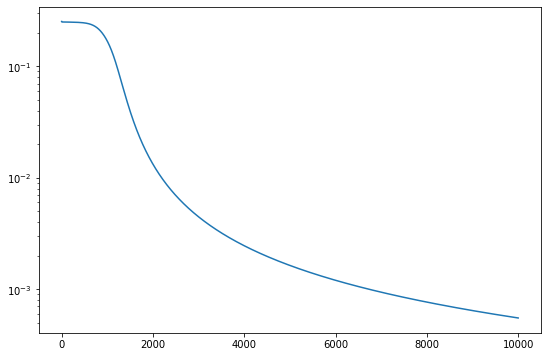

In [37]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [38]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', MSE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 5.8002076 , -4.5333486 ],
       [-0.70905   , -1.4249772 ],
       [ 0.12139115,  0.40630925],
       [-5.879942  , -5.813326  ],
       [-1.0328453 , -1.5517629 ],
       [ 0.8686707 ,  0.34425804],
       [ 1.5183951 , -3.546849  ],
       [ 0.272205  , -1.6575692 ],
       [ 0.3805049 ,  0.79971266],
       [ 0.43659213, -2.867566  ]], dtype=float32), array([[-7.5230985 ,  2.558237  , -0.02016862, -8.695462  ,  3.0801833 ,
        -0.6048784 ,  4.0506773 ,  1.8794022 , -0.7869709 ,  3.4790454 ]],
      dtype=float32)]
Optimized Biases:  [array([ 2.1676874 ,  1.4459535 , -0.02873358,  2.1704962 ,  1.910525  ,
       -0.40493715, -0.35466686,  0.14542168, -0.45517248,  0.62964845],
      dtype=float32), array([1.4907433], dtype=float32)]
Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[8.9731008e-01, 8.0937487e-01, 4.9281710e-01, 8.9756858e-01,
        8.7107813

In [39]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
4.720688e-05
4.2319298e-05

Layer :  2
9.727478e-05
1.1563301e-05


## ** NEW METHOD ** With opt_einsum expressions (It is faster than np.einsum but only slightly)

In [40]:
%%time
# Run optimization
optWeights, optBiases, errorPlot = nn_optimize_fast(inputs, outputs, activation_func_names, nLayers, nEpochs=nEpochs, batchSize=batchSize, eeta=eeta, weights=weightsOriginal, biases=biasesOriginal, errorFunc=MSE_loss, gradErrorFunc=MSE_loss_grad,miniterEpoch=100,batchProgressBar=False,miniterBatch=100)



  0%|          | 0/10000 [00:00<?, ?it/s]

Average Error with initial weights and biases: 0.2528499364852905
Wall time: 1.41 s


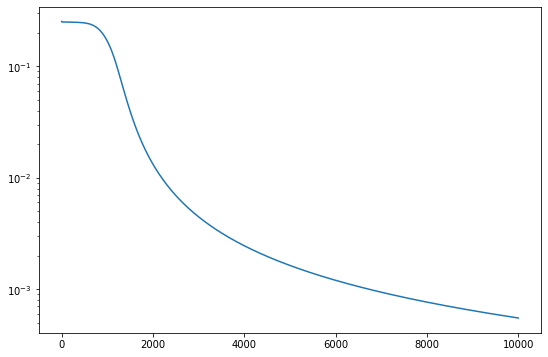

In [41]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [42]:
# Optimized weights and biases
print('Optimized Weights: ', optWeights)
print('Optimized Biases: ', optBiases)
# Forward feed with optimized weights
# Perform Forward feed and get the outputs at each layers and the inputs at each layer
a, z = forward_feed(inputs, nLayers, optWeights, optBiases, activation_func_names)
print('Outputs at each layer (including input layer):\n ',a)
print('Inputs at each layer :\n ', z)
# New Error
print('New Average Error with optimized weights:\n', BCE_loss(a[nLayers],outputs)/batchSize)
print('Input: ',inputs)
print('Output: ',a[nLayers])
print('Expected Output: ',outputs)

Optimized Weights:  [array([[ 5.800208  , -4.533348  ],
       [-0.7090489 , -1.4249768 ],
       [ 0.12139126,  0.4063093 ],
       [-5.879942  , -5.813326  ],
       [-1.032847  , -1.551763  ],
       [ 0.8686708 ,  0.34425822],
       [ 1.5183972 , -3.5468514 ],
       [ 0.27220467, -1.6575687 ],
       [ 0.38050535,  0.79971206],
       [ 0.43659058, -2.8675647 ]], dtype=float32), array([[-7.523097  ,  2.5582352 , -0.02016898, -8.695462  ,  3.0801845 ,
        -0.6048792 ,  4.050679  ,  1.8794022 , -0.78697175,  3.479044  ]],
      dtype=float32)]
Optimized Biases:  [array([ 2.1676867 ,  1.4459518 , -0.02873362,  2.1704965 ,  1.9105268 ,
       -0.4049374 , -0.3546683 ,  0.14542167, -0.45517257,  0.6296495 ],
      dtype=float32), array([1.4907438], dtype=float32)]
Outputs at each layer (including input layer):
  [array([[0., 0.],
       [0., 1.],
       [1., 0.],
       [1., 1.]], dtype=float32), array([[8.9731002e-01, 8.0937463e-01, 4.9281710e-01, 8.9756864e-01,
        8.7107831

In [43]:
print('Difference b/w our weights & biases and keras results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(optWeights[i]-model.layers[i].get_weights()[0].T).max())
    print(abs(optBiases[i]-model.layers[i].get_weights()[1].T).max())

Difference b/w our weights & biases and keras results:

Layer :  1
4.506111e-05
4.053116e-05

Layer :  2
9.870529e-05
1.1086464e-05


# PyTorch

In [44]:
### Choose device: 'cuda' or 'cpu'
device = 'cpu'
# device = 'cuda'

## Generate the network programatically

## Method 1

In [45]:
Layers = []
# Input layer
Layers.append(torch.nn.Linear(nInputs, neurons_per_layer[0]))
Layers.append(torch.nn.Sigmoid())

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Layers.append(torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Layers.append(torch.nn.Sigmoid())
    # Output layer
    Layers.append(torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Layers.append(torch.nn.Sigmoid())

In [46]:
Network = torch.nn.Sequential(*Layers)

In [47]:
print(Network)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=10, out_features=1, bias=True)
  (3): Sigmoid()
)


## Method 2 (Suitable for us to modify weights for each layer to be same as keras and my implementation)

In [48]:
Network = torch.nn.Sequential()
 
# Input layer -> 1st hidden layer
Network.add_module(str(0),torch.nn.Linear(nInputs, neurons_per_layer[0]))
# Activation function after first hidden layer
Network.add_module('act0',act_func_dict_PyTorch[activation_func_names[0]])

if nLayers>1:
    # Hidden layers
    for i in range(1,nLayers-1):
        Network.add_module(str(i),torch.nn.Linear(neurons_per_layer[i-1], neurons_per_layer[i]))
        Network.add_module('act'+str(i),act_func_dict_PyTorch[activation_func_names[i]])
        
    # Output layer
    Network.add_module(str(nLayers-1),torch.nn.Linear(neurons_per_layer[nLayers-2], neurons_per_layer[nLayers-1]))
    Network.add_module('act'+str(nLayers-1),act_func_dict_PyTorch[activation_func_names[nLayers-1]])

In [49]:
# torch.nn.init.constant_(Network.weight, 2.0)
Network.to(device=device)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=10, out_features=1, bias=True)
  (act1): Sigmoid()
)

## initial weights and biases generated by Pytorch

In [50]:
print(Network[0].weight)
print(Network[0].bias)

Parameter containing:
tensor([[-0.6451,  0.5386],
        [-0.1864,  0.3398],
        [-0.3626, -0.0879],
        [ 0.3140, -0.2799],
        [-0.5616,  0.1142],
        [ 0.1044, -0.5317],
        [-0.4736, -0.0306],
        [ 0.4386,  0.3348],
        [ 0.5996, -0.0984],
        [-0.1515,  0.6481]], requires_grad=True)
Parameter containing:
tensor([ 0.5150, -0.1271, -0.1657, -0.1864,  0.6504,  0.1303, -0.5448,  0.6880,
        -0.6417, -0.4292], requires_grad=True)


## Change them to be the same as others

## **IMPORTANT NOTE**: The returned tensor and the original array share the same memory. So any changes to the tensor change the array as well.

Reference: https://pytorch.org/docs/stable/generated/torch.from_numpy.html



In [51]:
for i in range(nLayers):
    # Weights
#     Network._modules[str(i)].weight.data = torch.from_numpy(weightsOriginal[i]).to(dtype=torch.float32)
    Network._modules[str(i)].weight.data = torch.tensor(weightsOriginal[i]).to(dtype=torch.float32)
    # Biases
#     Network._modules[str(i)].bias.data = torch.from_numpy(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32
    Network._modules[str(i)].bias.data = torch.tensor(biasesOriginal[i]).to(dtype=torch.float32) # Convert to float32

In [52]:
for i in range(nLayers):
    # Weights
    print('Weights:\n')
    print(Network._modules[str(i)].weight.data)
    # Biases
    print('Biases:\n')
    print(Network._modules[str(i)].bias.data)

Weights:

tensor([[ 0.7028, -0.5718],
        [-0.2573, -0.4663],
        [ 0.0746,  0.3282],
        [-0.6666, -0.1340],
        [-0.0525, -0.0953],
        [ 0.6774,  0.2289],
        [ 0.1840, -0.3113],
        [ 0.4483, -0.3396],
        [-0.0024,  0.0631],
        [-0.1110, -0.5714]])
Biases:

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Weights:

tensor([[-0.3634,  0.0976, -0.0774, -0.5338,  0.4418, -0.3094,  0.5570,  0.0435,
         -0.5439,  0.3741]])
Biases:

tensor([0.])


In [53]:
### Get information about model
totpars = 0
for par in Network.parameters():
    newpars = 1
    for num in par.shape:
        newpars *= num
    totpars += newpars
print(Network)
print('%i trainable parameters' % totpars)

### Initialize loss function and optimizer
# crit = torch.nn.BCELoss()
# opt = torch.optim.SGD(Network.parameters(), lr=0.2)

crit = torch.nn.MSELoss()
opt = torch.optim.SGD(Network.parameters(), lr=eeta)

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (act0): Sigmoid()
  (1): Linear(in_features=10, out_features=1, bias=True)
  (act1): Sigmoid()
)
41 trainable parameters


In [54]:
inputsTorch = torch.from_numpy(inputs)
inputsTorch = inputsTorch.to(dtype=torch.float32) # Convert to float32
labels = torch.from_numpy(outputs)
labels = labels.to(dtype=torch.float32) # Convert to float32

In [55]:
print(inputsTorch)
print(labels)

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.]])
tensor([[0.],
        [1.],
        [1.],
        [0.]])


In [56]:
%%time
### Set model in training mode and create the epochs axis
Network.train()
epochs = range(1, nEpochs)
errorPlot = []
### Train the model
for e in tqdm(epochs,leave=True,miniters=100):
    tr_loss = 0.
    samples = 0
    
    opt.zero_grad() # zero gradient values
    inputsTorch = inputsTorch.to(device=device) # move input and label tensors to the device with the model
    labels = labels.to(device=device)
    outputsTorch = Network(inputsTorch) # compute model outputs
    loss = crit(outputsTorch, labels) # compute batch loss
    loss.backward() # back-propagate the gradients
    opt.step() # update the model weights
    tr_loss += loss.clone().cpu().item()*len(inputsTorch) # add the batch loss to the running loss
    samples += len(inputsTorch) # update the number of processed samples
    tr_loss /= samples # compute training loss
    errorPlot.append(tr_loss)
#     print(e, tr_loss)

  0%|          | 0/9999 [00:00<?, ?it/s]

Wall time: 2.3 s


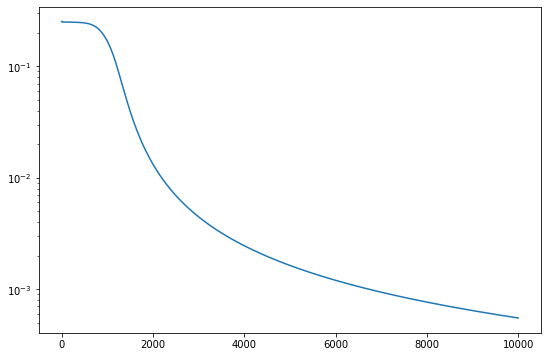

In [57]:
# Plot the error vs epochs
plt.plot(errorPlot)
plt.yscale('log')
plt.show()

In [58]:
print('Difference b/w our weights & biases and PyTorch results:')
for i in range(nLayers):
    print('\nLayer : ',i+1)
    print(abs(torch.tensor(optWeights[i]).to(dtype=torch.float32)-Network._modules[str(i)].weight.data).max())
    print(abs(torch.tensor(optBiases[i]).to(dtype=torch.float32)-Network._modules[str(i)].bias.data).max())

Difference b/w our weights & biases and PyTorch results:

Layer :  1
tensor(4.7326e-05)
tensor(4.3392e-05)

Layer :  2
tensor(9.7752e-05)
tensor(1.4186e-05)


In [59]:
torch.get_num_threads()

8

In [60]:
# torch.set_num_threads(4)
torch.get_num_threads()

8

In [61]:
torch.get_num_threads()

8